# Extend to EOC

Use EQW to extend to end of century

Inputs:
* Harmonised GHG total until 2050

Outputs:
* Full set of gases to run through MAGICC till 2100

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import os

import silicone.database_crunchers
from silicone.time_projectors import ExtendLatestTimeQuantile
import scmdata
import scmdata.database
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from ndcs.infilling import extend_timeseries, calc_ghg, kyoto_ghg_exclude_co2_vars
from ndcs.constants import PROCESSED_DATA_DIR, NDC_TARGET_RELEASE, RAW_DATA_DIR, LEAD

<IPython.core.display.Javascript object>

/home/jared/miniconda3/envs/ndc-realisations-2021/lib/python3.9/site-packages/scmdata/database.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

In [4]:
plt.rcParams["figure.figsize"] = (12, 8)

<IPython.core.display.Javascript object>

In [5]:
GLOBAL_DATABASE_DIR = os.path.join(
    PROCESSED_DATA_DIR, "global_emissions_pathways", NDC_TARGET_RELEASE
)

<IPython.core.display.Javascript object>

In [6]:
global_db = scmdata.database.ScmDatabase(
    GLOBAL_DATABASE_DIR,
    levels=(
        "ambition",
        "conditionality",
        "country_extension",
        "exclude_hot_air",
        "pathway_id",
        "global_extension",
    ),
)
global_db

<scmdata.database.SCMDatabase (root_dir: /home/jared/code/cr/ndc-realisations-2021/src/ndcs/../../data/processed/global_emissions_pathways/12Nov2021a_CR, levels: ('ambition', 'conditionality', 'country_extension', 'exclude_hot_air', 'pathway_id', 'global_extension'))>

<IPython.core.display.Javascript object>

In [7]:
# For these scenarios we process every pathway
input_scenarios_complete = global_db.load(
    country_extension=["SSP1BL"],
    conditionality=["C", "U"],
    exclude_hot_air="exclude",
    global_extension="n/a",
)

Loading files:   0%|          | 0/1416 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [8]:
latest_pathway_id = sorted(input_scenarios_complete.get_unique_meta("pathway_id"))[-1]
latest_pathway_id

'2021-11-09_1'

<IPython.core.display.Javascript object>

In [9]:
# We include all of the latest pathways for our sensitivity case study
input_scenarios_latest = global_db.load(
    pathway_id=latest_pathway_id, global_extension="n/a"
)
input_scenarios_latest.get_unique_meta("scenario")

Loading files:   0%|          | 0/48 [00:00<?, ?it/s]

['2021-11-09_1__high__R__2030__exclude',
 '2021-11-09_1__high__R__2030__include',
 '2021-11-09_1__high__R__SSP1BL__exclude',
 '2021-11-09_1__high__R__SSP1BL__include',
 '2021-11-09_1__high__R__rate__exclude',
 '2021-11-09_1__high__R__rate__include',
 '2021-11-09_1__high__R__constant__exclude',
 '2021-11-09_1__high__R__constant__include',
 '2021-11-09_1__high__C__2030__exclude',
 '2021-11-09_1__high__C__2030__include',
 '2021-11-09_1__high__C__SSP1BL__exclude',
 '2021-11-09_1__high__C__SSP1BL__include',
 '2021-11-09_1__high__C__rate__exclude',
 '2021-11-09_1__high__C__rate__include',
 '2021-11-09_1__high__C__constant__exclude',
 '2021-11-09_1__high__C__constant__include',
 '2021-11-09_1__high__U__2030__exclude',
 '2021-11-09_1__high__U__2030__include',
 '2021-11-09_1__high__U__SSP1BL__exclude',
 '2021-11-09_1__high__U__SSP1BL__include',
 '2021-11-09_1__high__U__rate__exclude',
 '2021-11-09_1__high__U__rate__include',
 '2021-11-09_1__high__U__constant__exclude',
 '2021-11-09_1__high__U__

<IPython.core.display.Javascript object>

In [10]:
input_scenarios_latest

<ScmRun (timeseries: 48, timepoints: 41)>
Time:
	Start: 2010-01-01T00:00:00
	End: 2050-01-01T00:00:00
Meta:
	   ambition conditionality country_extension        date exclude_hot_air global_extension last_country          model    pathway_id  pathway_num  pathway_num_today region                                  scenario        unit  \
	0      high              R              2030  2021-11-09         exclude              n/a          VEN  NDC Factsheet  2021-11-09_1          354                  1  World      2021-11-09_1__high__R__2030__exclude  Mt CO2 /yr   
	1      high              R              2030  2021-11-09         include              n/a          VEN  NDC Factsheet  2021-11-09_1          354                  1  World      2021-11-09_1__high__R__2030__include  Mt CO2 /yr   
	2      high              R            SSP1BL  2021-11-09         exclude              n/a          VEN  NDC Factsheet  2021-11-09_1          354                  1  World    2021-11-09_1__high__R__SSP1BL_

<IPython.core.display.Javascript object>

In [11]:
input_scenarios = scmdata.run_append(
    [
        input_scenarios_complete.filter(pathway_id=latest_pathway_id, keep=False),
        input_scenarios_latest,
    ]
)
input_scenarios["stage"] = "clean"
input_scenarios

<ScmRun (timeseries: 1460, timepoints: 41)>
Time:
	Start: 2010-01-01T00:00:00
	End: 2050-01-01T00:00:00
Meta:
	     ambition conditionality country_extension        date exclude_hot_air global_extension last_country  ... pathway_num pathway_num_today  region                                 scenario  stage        unit                          variable
	0        high              C            SSP1BL  2021-08-02         exclude              n/a          COG  ...         309                 1   World   2021-08-02_1__high__C__SSP1BL__exclude  clean  Mt CO2 /yr  Emissions|Total GHG excl. LULUCF
	1        high              C            SSP1BL  2021-10-10         exclude              n/a          PSE  ...         325                 1   World   2021-10-10_1__high__C__SSP1BL__exclude  clean  Mt CO2 /yr  Emissions|Total GHG excl. LULUCF
	2        high              C            SSP1BL  2021-04-16         exclude              n/a          MKD  ...         277                 1   World   2021-04-16

<IPython.core.display.Javascript object>

In [12]:
input_scenarios.get_unique_meta("global_extension")

['n/a']

<IPython.core.display.Javascript object>

In [13]:
# pathway_ids = sorted(input_scenarios.get_unique_meta("pathway_id"))[-15:]
# pathway_ids

<IPython.core.display.Javascript object>

In [14]:
# input_scenarios = input_scenarios.filter(pathway_id=pathway_ids)

<IPython.core.display.Javascript object>

In [15]:
input_scenarios.timeseries()

time                                                                                                                                                                                                                                                             2010-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extension last_country model         pathway_id    pathway_num pathway_num_today region scenario                                stage unit       variable                                         
high     C              SSP1BL            2021-08-02 exclude         n/a              COG          NDC Factsheet 2021-08-02_1  309         1                 World  2021-08-02_1__high__C__SSP1BL__exclude  clean Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.555590   
                                          2021-10-10 exclude         n/a              PSE          NDC Factsheet 2021-10-10_1  325         1                 World  2021-10-10_1__high__C__SSP1BL__exclude  clean Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.555590   
                                          2021-04-16 exclude         n/a              MKD          NDC Factsheet 2021-04-16_1  277         1                 World  2021-04-16_1__high__C__SSP1BL__exclude  clean Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.555590   
                                          2018-11-30 exclude         n/a              SYR          NDC Factsheet 2018-11-30_1  193         1                 World  2018-11-30_1__high__C__SSP1BL__exclude  clean Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45113.146990   
                                          2020-12-09 exclude         n/a              NPL          NDC Factsheet 2020-12-09_3  219         3                 World  2020-12-09_3__high__C__SSP1BL__exclude  clean Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45086.288422   
                                          2016-10-20 exclude         n/a              DZA          NDC Factsheet 2016-10-20_1  90          1                 World  2016-10-20_1__high__C__SSP1BL__exclude  clean Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45212.940466   
                                          2017-03-27 exclude         n/a              SLV          NDC Factsheet 2017-03-27_1  150         1                 World  2017-03-27_1__high__C__SSP1BL__exclude  clean Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45113.457373   
                                          2017-12-13 exclude         n/a              COD          NDC Factsheet 2017-12-13_1  179         1                 World  2017-12-13_1__high__C__SSP1BL__exclude  clean Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45050.548470   
                                          2016-11-02 exclude         n/a              STP          NDC Factsheet 2016-11-02_2  102         2                 World  2016-11-02_2__high__C__SSP1BL__exclude  clean Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45215.693698   
                                          2020-12-18 exclude         n/a              MLT          NDC Factsheet 2020-12-18_20 244         20                World  2020-12-18_20__high__C__SSP1BL__exclude clean Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.854860   
...                                                                                                                                                                                                                                                                     ...   
low      C              constant          2021-11-09 exclude         n/a              VEN          NDC Factsheet 2021-11-09_1  354         1                 World  2021-11-09_1__low__C__constant__exclude clean Mt CO2 /yr Emissions|Total GHG excl. LULUCF  45085.555590   
                                                     include         n/a              VEN          NDC Factsheet 2021-11-09_1  354         1                 World  2021-11-09_1__low__C__constant__include cl

<IPython.core.display.Javascript object>

# Prep SR15 data for infilling

In [16]:
# harmonised using reduce_ratio_2080
sr15_scenarios_harmonised = scmdata.ScmRun(
    os.path.join(
        RAW_DATA_DIR, "sr15-scenarios", "sr15_scenarios_default-c4c98252789fe3be.csv"
    ),
    lowercase_cols=True,
).resample("AS")

<IPython.core.display.Javascript object>

In [17]:
sr15_scenarios_harmonised["variable"] = [
    s.replace("Emissions|VOC", "Emissions|NMVOC")
    .replace("Emissions|HFC4310mee", "Emissions|HFC4310")
    .replace("Emissions|Sulfur", "Emissions|SOx")
    for s in sr15_scenarios_harmonised["variable"]
]

<IPython.core.display.Javascript object>

In [18]:
sr15_scenarios_harmonised.get_unique_meta("variable")

['Emissions|BC',
 'Emissions|C2F6',
 'Emissions|C6F14',
 'Emissions|CF4',
 'Emissions|CO',
 'Emissions|HFC125',
 'Emissions|HFC134a',
 'Emissions|HFC143a',
 'Emissions|HFC227ea',
 'Emissions|HFC23',
 'Emissions|HFC245fa',
 'Emissions|HFC32',
 'Emissions|HFC4310',
 'Emissions|NMVOC',
 'Emissions|OC',
 'Emissions|SF6',
 'Emissions|SOx',
 'Emissions|NH3',
 'Emissions|NOx',
 'Emissions|CO2|MAGICC AFOLU',
 'Emissions|CO2|MAGICC Fossil and Industrial',
 'Emissions|N2O',
 'Emissions|CH4']

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='time', ylabel='Mt CO2 / yr'>

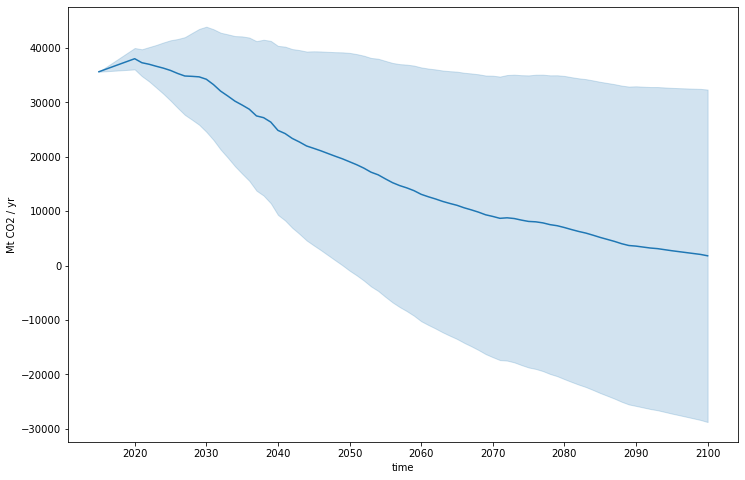

<IPython.core.display.Javascript object>

In [19]:
sr15_scenarios_harmonised.filter(variable="Emissions|CO2|MAGICC Fo*").lineplot(hue=None)

In [20]:
sr15_scenarios = sr15_scenarios_harmonised
sr15_scenarios.get_unique_meta("variable")

['Emissions|BC',
 'Emissions|C2F6',
 'Emissions|C6F14',
 'Emissions|CF4',
 'Emissions|CO',
 'Emissions|HFC125',
 'Emissions|HFC134a',
 'Emissions|HFC143a',
 'Emissions|HFC227ea',
 'Emissions|HFC23',
 'Emissions|HFC245fa',
 'Emissions|HFC32',
 'Emissions|HFC4310',
 'Emissions|NMVOC',
 'Emissions|OC',
 'Emissions|SF6',
 'Emissions|SOx',
 'Emissions|NH3',
 'Emissions|NOx',
 'Emissions|CO2|MAGICC AFOLU',
 'Emissions|CO2|MAGICC Fossil and Industrial',
 'Emissions|N2O',
 'Emissions|CH4']

<IPython.core.display.Javascript object>

In [21]:
sr15_scenarios["id"] = sr15_scenarios["model"] + "_" + sr15_scenarios["scenario"]

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='time', ylabel='Mt CO2 / yr'>

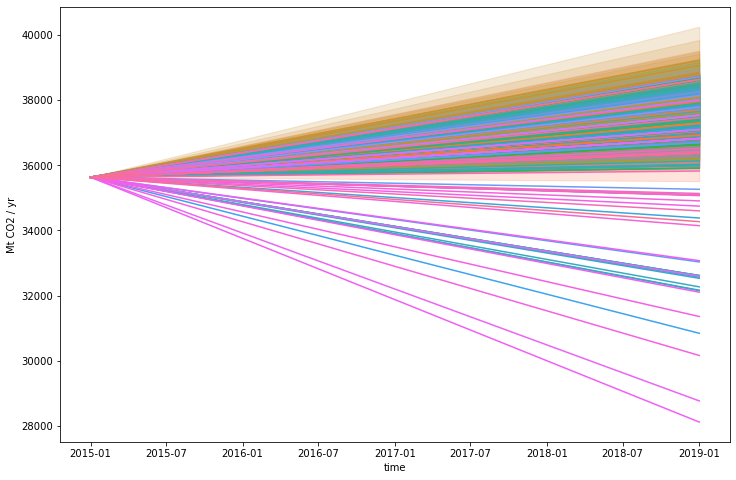

<IPython.core.display.Javascript object>

In [22]:
sr15_scenarios.filter(
    variable="Emissions|CO2|MAGICC Fossil and Industrial", year=range(2000, 2020)
).lineplot(legend=False)

In [23]:
sr15_scenarios.get_unique_meta("variable")

['Emissions|BC',
 'Emissions|C2F6',
 'Emissions|C6F14',
 'Emissions|CF4',
 'Emissions|CO',
 'Emissions|HFC125',
 'Emissions|HFC134a',
 'Emissions|HFC143a',
 'Emissions|HFC227ea',
 'Emissions|HFC23',
 'Emissions|HFC245fa',
 'Emissions|HFC32',
 'Emissions|HFC4310',
 'Emissions|NMVOC',
 'Emissions|OC',
 'Emissions|SF6',
 'Emissions|SOx',
 'Emissions|NH3',
 'Emissions|NOx',
 'Emissions|CO2|MAGICC AFOLU',
 'Emissions|CO2|MAGICC Fossil and Industrial',
 'Emissions|N2O',
 'Emissions|CH4']

<IPython.core.display.Javascript object>

In [24]:
contexts = ["AR6GWP100", "AR5GWP100", "AR4GWP100"]

sr15_scenarios_ghg = []


for context in contexts:
    ghgeq = calc_ghg(
        sr15_scenarios, include_vars=kyoto_ghg_exclude_co2_vars, context=context
    )

    sr15_scenarios_ghg.append(ghgeq)

sr15_scenarios_ghg = scmdata.run_append(sr15_scenarios_ghg)
sr15_scenarios_ghg.timeseries()

time                                                                                                                                                                                                                   2015-01-01    2016-01-01  \
climate_model id                                                     model               region scenario                                       stage      todo unit        variable                                                               
unspecified   AIM_2_0_ADVANCE_2020_1.5C-2100                         AIM_2_0             World  ADVANCE_2020_1.5C-2100                         harmonised SET  Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50802.393146  51494.530333   
              IMAGE_3_0_1_ADVANCE_2020_1.5C-2100                     IMAGE_3_0_1         World  ADVANCE_2020_1.5C-2100                         harmonised SET  Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50802.393146  51034.167633   
              MESSAGE-GLOBIOM_1_0_ADVANCE_2020_1.5C-2100             MESSAGE-GLOBIOM_1_0 World  ADVANCE_2020_1.5C-2100                         harmonised SET  Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50802.393146  51050.842831   
              POLES_ADVANCE_ADVANCE_2020_1.5C-2100                   POLES_ADVANCE       World  ADVANCE_2020_1.5C-2100                         harmonised SET  Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50802.393146  51601.297114   
              REMIND_1_7_ADVANCE_2020_1.5C-2100                      REMIND_1_7          World  ADVANCE_2020_1.5C-2100                         harmonised SET  Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50802.393146  51509.625943   
              WITCH-GLOBIOM_4_2_ADVANCE_2020_1.5C-2100               WITCH-GLOBIOM_4_2   World  ADVANCE_2020_1.5C-2100                         harmonised SET  Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50802.393146  50831.257250   
              AIM_2_0_ADVANCE_2020_Med2C                             AIM_2_0             World  ADVANCE_2020_Med2C                             harmonised SET  Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50802.393146  51477.475235   
              IMAGE_3_0_1_ADVANCE_2020_Med2C                         IMAGE_3_0_1         World  ADVANCE_2020_Med2C                             harmonised SET  Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50802.393146  51123.694021   
              MESSAGE-GLOBIOM_1_0_ADVANCE_2020_Med2C                 MESSAGE-GLOBIOM_1_0 World  ADVANCE_2020_Med2C                             harmonised SET  Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50802.393146  51051.275182   
              POLES_ADVANCE_ADVANCE_2020_Med2C                       POLES_ADVANCE       World  ADVANCE_2020_Med2C                             harmonised SET  Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50802.393146  51601.221274   
...                                                                                                                                                                                                                           ...           ...   
              AIM_2_0_SocioeconomicFactorCM_SSP2_SupTech_Baseline    AIM_2_0             World  SocioeconomicFactorCM_SSP2_SupTech_Baseline    harmonised SET  Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR4GWP100)  49846.415646  50808.697701   
              AIM_2_0_SocioeconomicFactorCM_SSP2_combined_1p5Degree  AIM_2_0             World  SocioeconomicFactorCM_SSP2_combined_1p5Degree  harmonised SET  Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR4GWP100)  49846.415646  49812.573319   
              AIM_2_0_SocioeconomicFactorCM_SSP2_combined_2Degree    AIM_2_0             World  SocioeconomicFactorCM_SSP2_combined_2Degree    harmonised SET  Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR4GWP100)  49846.415646  49812.573319   
              AIM_2_0_SocioeconomicFactorCM_SSP2_combined_Baseline   AIM_2_0             World  SocioeconomicFac

<IPython.core.display.Javascript object>

In [25]:
sr15_scenarios_ghg

<ScmRun (timeseries: 1233, timepoints: 86)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	     climate_model                                                      id                model region                                        scenario       stage todo         unit                                  variable
	0      unspecified                          AIM_2_0_ADVANCE_2020_1.5C-2100              AIM_2_0  World                          ADVANCE_2020_1.5C-2100  harmonised  SET  Mt CO2 / yr  Emissions|GHG excl CO2 AFOLU (AR6GWP100)
	1      unspecified                      IMAGE_3_0_1_ADVANCE_2020_1.5C-2100          IMAGE_3_0_1  World                          ADVANCE_2020_1.5C-2100  harmonised  SET  Mt CO2 / yr  Emissions|GHG excl CO2 AFOLU (AR6GWP100)
	2      unspecified              MESSAGE-GLOBIOM_1_0_ADVANCE_2020_1.5C-2100  MESSAGE-GLOBIOM_1_0  World                          ADVANCE_2020_1.5C-2100  harmonised  SET  Mt CO2 / yr  Emissions|GHG excl CO2 AFOLU (AR6GW

<IPython.core.display.Javascript object>

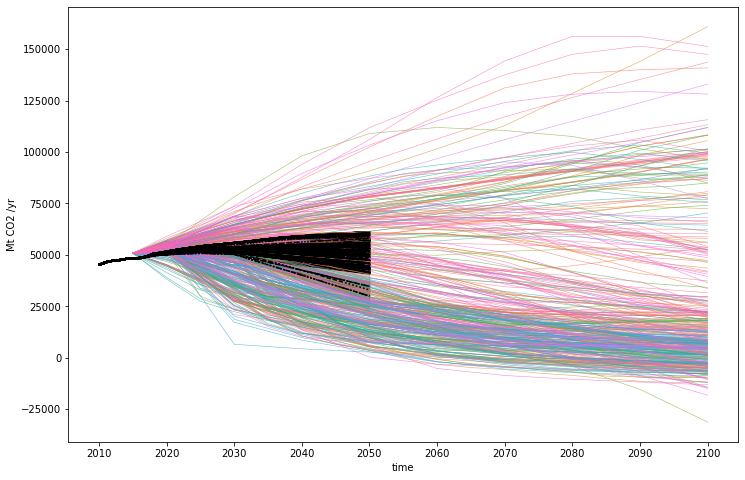

<IPython.core.display.Javascript object>

In [26]:
sr15_scenarios_ghg.filter(variable="*(AR6GWP100)").line_plot(
    hue="model", units="id", estimator=None, legend=False, lw=0.6, alpha=0.7
)
input_scenarios.line_plot(color="black", hue=None, style="pathway_id", legend=False)

# Basic Harmonisation

Harmonise the input scenarios to the harmonised SR1.5 values for GHG excl CO2 AFOLU

In [27]:
SCALING_YEAR = 2015

<IPython.core.display.Javascript object>

In [28]:
values_2010 = sr15_scenarios_ghg.filter(
    year=SCALING_YEAR,
    variable="Emissions|GHG excl CO2 AFOLU (AR6GWP100)",
    region="World",
).values.mean()

<IPython.core.display.Javascript object>

In [29]:
scaling_factor = values_2010 / input_scenarios.filter(year=SCALING_YEAR).values[0]
scaling_factor = scaling_factor.squeeze()
scaling_factor
# This factor is high because 1. we already harmonised in a previous step to a different history and 2. the GHG emissions still include AFOLU

array(1.05345812)

<IPython.core.display.Javascript object>

In [30]:
input_scenarios_harmonised = input_scenarios * float(scaling_factor)
input_scenarios_harmonised["stage"] = "harmonised"
input_scenarios_harmonised

<ScmRun (timeseries: 1460, timepoints: 41)>
Time:
	Start: 2010-01-01T00:00:00
	End: 2050-01-01T00:00:00
Meta:
	     ambition conditionality country_extension        date exclude_hot_air global_extension last_country  ... pathway_num pathway_num_today  region                                 scenario       stage        unit                          variable
	0        high              C            SSP1BL  2021-08-02         exclude              n/a          COG  ...         309                 1   World   2021-08-02_1__high__C__SSP1BL__exclude  harmonised  Mt CO2 /yr  Emissions|Total GHG excl. LULUCF
	1        high              C            SSP1BL  2021-10-10         exclude              n/a          PSE  ...         325                 1   World   2021-10-10_1__high__C__SSP1BL__exclude  harmonised  Mt CO2 /yr  Emissions|Total GHG excl. LULUCF
	2        high              C            SSP1BL  2021-04-16         exclude              n/a          MKD  ...         277                 1   Wor

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='time', ylabel='Mt CO2 /yr'>

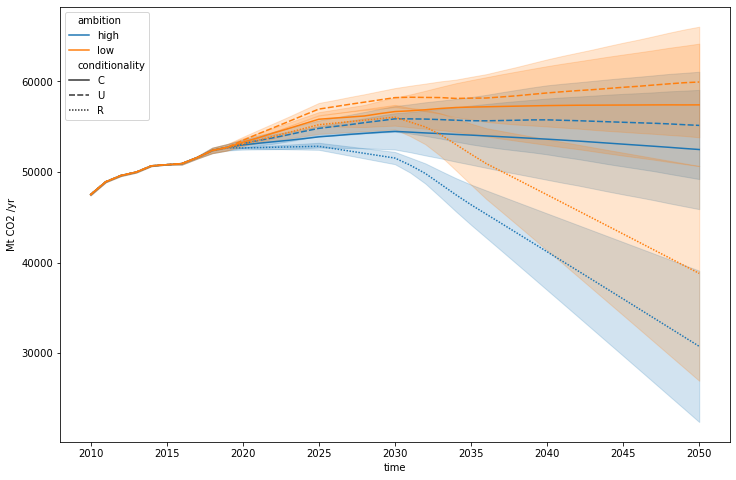

<IPython.core.display.Javascript object>

In [31]:
input_scenarios_harmonised.lineplot(hue="ambition", style="conditionality")


# Extend using GHG quantiles

In [32]:
START_YEAR = 2015
END_YEAR = 2050  # For ndc scenarios
LEAD = "Emissions|GHG excl CO2 AFOLU (AR6GWP100)"
CONTEXT = "AR6GWP100"
SELECTED_PATHWAY = "2021-10-18_1"
# SELECTED_PATHWAY = "high_R_rate"

<IPython.core.display.Javascript object>

In [34]:
sr15_data = scmdata.run_append([sr15_scenarios_ghg, sr15_scenarios])
sr15_data["id"] = sr15_data["model"] + "_" + sr15_data["scenario"]
sr15_data_cleaned = sr15_data.filter(year=range(START_YEAR, 2101))

<IPython.core.display.Javascript object>

In [35]:
sr15_data_cleaned.to_csv(os.path.join(PROCESSED_DATA_DIR, "sr15_data.csv"))

<IPython.core.display.Javascript object>

In [36]:
sr15_data_cleaned

<ScmRun (timeseries: 10686, timepoints: 86)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      climate_model                                          id                model region                scenario       stage todo         unit                                  variable
	0       unspecified              AIM_2_0_ADVANCE_2020_1.5C-2100              AIM_2_0  World  ADVANCE_2020_1.5C-2100  harmonised  SET  Mt CO2 / yr  Emissions|GHG excl CO2 AFOLU (AR6GWP100)
	1       unspecified          IMAGE_3_0_1_ADVANCE_2020_1.5C-2100          IMAGE_3_0_1  World  ADVANCE_2020_1.5C-2100  harmonised  SET  Mt CO2 / yr  Emissions|GHG excl CO2 AFOLU (AR6GWP100)
	2       unspecified  MESSAGE-GLOBIOM_1_0_ADVANCE_2020_1.5C-2100  MESSAGE-GLOBIOM_1_0  World  ADVANCE_2020_1.5C-2100  harmonised  SET  Mt CO2 / yr  Emissions|GHG excl CO2 AFOLU (AR6GWP100)
	3       unspecified        POLES_ADVANCE_ADVANCE_2020_1.5C-2100        POLES_ADVANCE  World  ADVANCE_2020_1.5C-2100  harmonised  SET

<IPython.core.display.Javascript object>

In [37]:
selected_scenario_clean = (
    input_scenarios.filter(pathway_id=SELECTED_PATHWAY)
    .convert_unit("Mt CO2 / yr")
    .filter(year=range(START_YEAR, END_YEAR + 1))
)
selected_scenario_clean

<ScmRun (timeseries: 4, timepoints: 36)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2050-01-01T00:00:00
Meta:
	  ambition conditionality country_extension        date exclude_hot_air global_extension last_country  ... pathway_num pathway_num_today  region                                scenario  stage         unit                          variable
	0     high              C            SSP1BL  2021-10-18         exclude              n/a          BHR  ...         343                 1   World  2021-10-18_1__high__C__SSP1BL__exclude  clean  Mt CO2 / yr  Emissions|Total GHG excl. LULUCF
	1      low              C            SSP1BL  2021-10-18         exclude              n/a          BHR  ...         343                 1   World   2021-10-18_1__low__C__SSP1BL__exclude  clean  Mt CO2 / yr  Emissions|Total GHG excl. LULUCF
	2     high              U            SSP1BL  2021-10-18         exclude              n/a          BHR  ...         343                 1   World  2021-10-18_1__high__U__SSP

<IPython.core.display.Javascript object>

In [40]:
selected_scenarios = input_scenarios_harmonised.convert_unit("Mt CO2 / yr").filter(
    year=range(START_YEAR, END_YEAR + 1)
)
selected_scenario = selected_scenarios.filter(pathway_id=SELECTED_PATHWAY)
selected_scenarios

<ScmRun (timeseries: 1460, timepoints: 36)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2050-01-01T00:00:00
Meta:
	     ambition conditionality country_extension        date exclude_hot_air global_extension last_country  ... pathway_num pathway_num_today  region                                 scenario       stage         unit                          variable
	0        high              C            SSP1BL  2021-08-02         exclude              n/a          COG  ...         309                 1   World   2021-08-02_1__high__C__SSP1BL__exclude  harmonised  Mt CO2 / yr  Emissions|Total GHG excl. LULUCF
	1        high              C            SSP1BL  2021-10-10         exclude              n/a          PSE  ...         325                 1   World   2021-10-10_1__high__C__SSP1BL__exclude  harmonised  Mt CO2 / yr  Emissions|Total GHG excl. LULUCF
	2        high              C            SSP1BL  2021-04-16         exclude              n/a          MKD  ...         277                 1   

<IPython.core.display.Javascript object>

In [42]:
selected_scenarios.filter(scenario="2021-11-09_1__low__U__2030__include").timeseries()

,,,,,,,,,,,,,,,time,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01,2021-01-01,...,2044-01-01,2045-01-01,2046-01-01,2047-01-01,2048-01-01,2049-01-01,2050-01-01
ambition,conditionality,country_extension,date,exclude_hot_air,global_extension,last_country,model,pathway_id,pathway_num,pathway_num_today,region,scenario,stage,unit,variable,,,,,,,,,,,,,,,
low,U,2030,2021-11-09,include,n/a,VEN,NDC Factsheet,2021-11-09_1,352,1,World,2021-11-09_1__low__U__2030__include,harmonised,Mt CO2 / yr,Emissions|Total GHG excl. LULUCF,50801.212705,50903.974352,51560.307077,52362.844746,52679.980833,53195.802007,53786.628503,...,60581.820968,60815.520157,61048.5811,61281.642043,61514.702985,61748.301401,61981.362344


<IPython.core.display.Javascript object>

In [39]:
pathways = selected_scenarios.get_unique_meta("pathway_id")

<IPython.core.display.Javascript object>

In [37]:
extended_scenario_all = scmdata.run_append(
    [
        extend_timeseries(sr15_data_cleaned, selected_scenarios.filter(pathway_id=p))
        for p in tqdm(pathways)
    ]
)
extended_scenario_2050 = extended_scenario_all.filter(pathway_id=SELECTED_PATHWAY)

  0%|          | 0/354 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [38]:
selected_scenarios.filter(pathway_id=SELECTED_PATHWAY)

<ScmRun (timeseries: 4, timepoints: 36)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2050-01-01T00:00:00
Meta:
	     ambition conditionality country_extension        date exclude_hot_air global_extension last_country  ... pathway_num pathway_num_today  region                                scenario       stage         unit                          variable
	328      high              C            SSP1BL  2021-10-18         exclude              n/a          BHR  ...         343                 1   World  2021-10-18_1__high__C__SSP1BL__exclude  harmonised  Mt CO2 / yr  Emissions|Total GHG excl. LULUCF
	681       low              C            SSP1BL  2021-10-18         exclude              n/a          BHR  ...         343                 1   World   2021-10-18_1__low__C__SSP1BL__exclude  harmonised  Mt CO2 / yr  Emissions|Total GHG excl. LULUCF
	1034     high              U            SSP1BL  2021-10-18         exclude              n/a          BHR  ...         343                 1   World 

<IPython.core.display.Javascript object>

In [39]:
# extended_scenario_2030 = extend_timeseries(
#     sr15_data_cleaned,
#     selected_scenarios.filter(pathway_id=SELECTED_PATHWAY).filter(
#         year=range(START_YEAR, 2030 + 1)
#     ),
# )

<IPython.core.display.Javascript object>

In [40]:
extended_scenario_2050

<ScmRun (timeseries: 4, timepoints: 86)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	     ambition conditionality country_extension        date exclude_hot_air global_extension last_country  ... pathway_num pathway_num_today  region                                scenario     stage         unit  \
	1312     high              C            SSP1BL  2021-10-18         exclude              n/a          BHR  ...         343                 1   World  2021-10-18_1__high__C__SSP1BL__exclude  extended  Mt CO2 / yr   
	1313     high              U            SSP1BL  2021-10-18         exclude              n/a          BHR  ...         343                 1   World  2021-10-18_1__high__U__SSP1BL__exclude  extended  Mt CO2 / yr   
	1314      low              C            SSP1BL  2021-10-18         exclude              n/a          BHR  ...         343                 1   World   2021-10-18_1__low__C__SSP1BL__exclude  extended  Mt CO2 / yr   
	1315      low              U    

<IPython.core.display.Javascript object>

In [41]:
extended_scenario_2050.filter(exclude_hot_air="exclude").head()

time                                                                                                                                                                                                                                                                       2015-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extension last_country model         pathway_id   pathway_num pathway_num_today region scenario                               stage    unit        variable                                                 
high     C              SSP1BL            2021-10-18 exclude         n/a              BHR          NDC Factsheet 2021-10-18_1 343         1                 World  2021-10-18_1__high__C__SSP1BL__exclude extended Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50801.212705   
         U              SSP1BL            2021-10-18 exclude         n/a              BHR          NDC Factsheet 2021-10-18_1 343         1                 World  2021-10-18_1__high__U__SSP1BL__exclude extended Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50801.212705   
low      C              SSP1BL            2021-10-18 exclude         n/a              BHR          NDC Factsheet 2021-10-18_1 343         1                 World  2021-10-18_1__low__C__SSP1BL__exclude  extended Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50801.212705   
         U              SSP1BL            2021-10-18 exclude         n/a              BHR          NDC Factsheet 2021-10-18_1 343         1                 World  2021-10-18_1__low__U__SSP1BL__exclude  extended Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50801.212705   

time                                                                                                                                                                                                                                                                       2016-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extension last_country model         pathway_id   pathway_num pathway_num_today region scenario                               stage    unit        variable                                                 
high     C              SSP1BL            2021-10-18 exclude         n/a              BHR          NDC Factsheet 2021-10-18_1 343         1                 World  2021-10-18_1__high__C__SSP1BL__exclude extended Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50904.230828   
         U              SSP1BL            2021-10-18 exclude         n/a              BHR          NDC Factsheet 2021-10-18_1 343         1                 World  2021-10-18_1__high__U__SSP1BL__exclude extended Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50904.230828   
low      C              SSP1BL            2021-10-18 exclude         n/a              BHR          NDC Factsheet 2021-10-18_1 343         1                 World  2021-10-18_1__low__C__SSP1BL__exclude  extended Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50904.230828   
         U              SSP1BL            2021-10-18 exclude         n/a              BHR          NDC Factsheet 2021-10-18_1 343         1                 World  2021-10-18_1__low__U__SSP1BL__exclude  extended Mt CO2 / yr Emissions|GHG excl CO2 AFOLU (AR6GWP100)  50904.230828   

time                                                                                                                                                                                                                                                                       2017-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extension last_country model         pathway_id   pathway_num pathway_num_today region scenario                               stage    unit        variable                                                 
high     C              SSP1BL            2021-10-18 exclude    

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Database CO$_2$ and lead emissions timeseries')

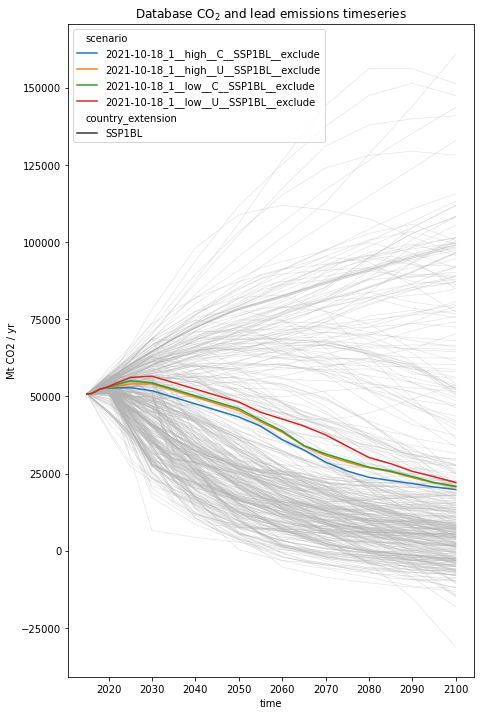

<IPython.core.display.Javascript object>

In [42]:
pkwargs = {
    "hue": None,
    "color": "0.7",
    "lw": 0.6,
    "alpha": 0.4,
    "units": "id",
    "estimator": None,
    "legend": False,
}

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(121)

sr15_data_cleaned.filter(variable=LEAD).lineplot(ax=ax, **pkwargs)
# extended_scenario_2050.lineplot(
#     ax=ax, hue="pathway_id", linestyle="--", dashes=(10, 15)
# )
extended_scenario_2050.filter(exclude_hot_air="exclude").lineplot(
    ax=ax, style="country_extension", estimator=None
)
ax.set_title("Database CO$_2$ and lead emissions timeseries")

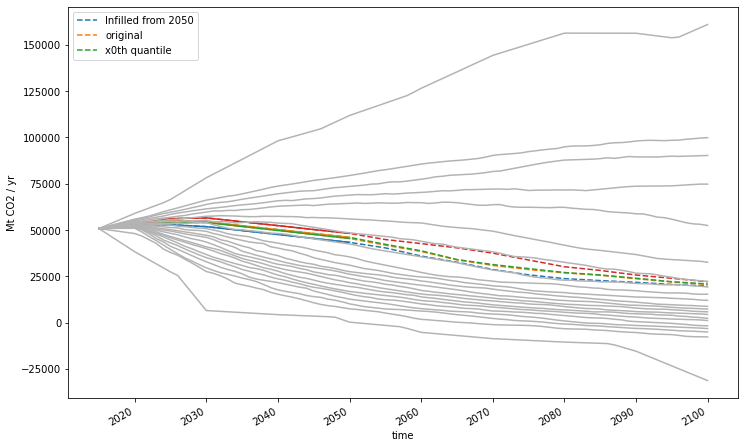

<IPython.core.display.Javascript object>

In [43]:
import numpy as np

extended_scenario_2050.filter(pathway_id=SELECTED_PATHWAY).lineplot(
    linestyle="--", dashes=(10, 15), label="Infilled from 2050", legend=False
)
# extended_scenario_2030.lineplot(
#     hue=None,
#     color="tab:orange",
#     linestyle="--",
#     dashes=(10, 15),
#     label="Infilled from 2030",
#     legend=False,
# )
selected_scenario.lineplot(label="original", legend=False)
sr15_data_cleaned.filter(variable=LEAD).quantiles_over(
    ("id", "scenario", "model", "category"), quantiles=np.arange(0, 1.01, 0.05)
).T.plot(ax=plt.gca(), legend=False, color="0.7")

plt.legend(["Infilled from 2050", "original", "x0th quantile"])

In [44]:
extended_scenario_all.to_csv(
    os.path.join(
        PROCESSED_DATA_DIR,
        "global_emissions_pathways",
        NDC_TARGET_RELEASE,
        "emissions_ghg_extended.csv",
    )
)

<IPython.core.display.Javascript object>

In [45]:
extended_subset = extended_scenario_all.filter(
    pathway_id=[
        "2021-10-18_1",
        "2021-10-28_1",
        "2021-10-28_2",
        "2021-10-30-1",
        "2021-11-01_1",
    ]
)

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Emissions|GHG excl CO2 AFOLU (AR6GWP100)')

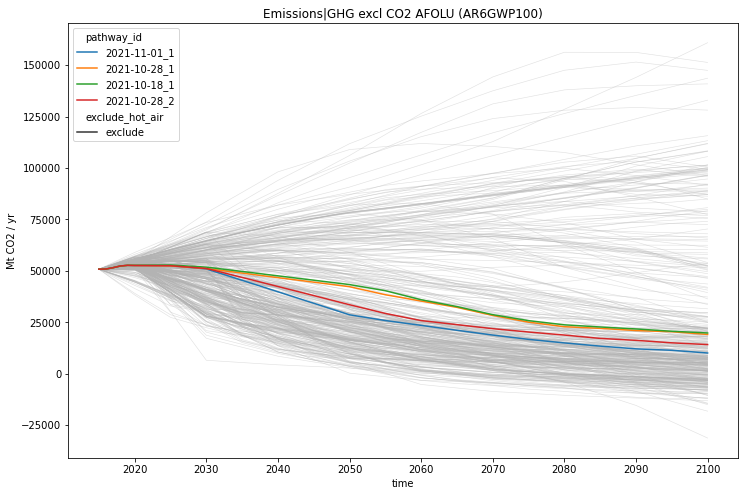

<IPython.core.display.Javascript object>

In [46]:
ax = plt.gca()

sr15_data_cleaned.filter(variable=LEAD).lineplot(ax=ax, **pkwargs)
extended_subset.filter(
    country_extension="SSP1BL",
    ambition="high",
    conditionality="C",
    year=range(2015, 2101),
).lineplot(ax=ax, hue="pathway_id", style="exclude_hot_air")
ax.set_title(extended_scenario_2050.get_unique_meta("variable", True))